# 18.369 pset 3, problem 2 solutions

First, we'll load up the Meep, Numpy (computation on arrays), and Matplotlib (plotting) packages, and tell Meep to be [less verbose](https://meep.readthedocs.io/en/latest/Python_User_Interface/#verbosity) about printing output.

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
mp.verbosity(0)

1

## Part (a)

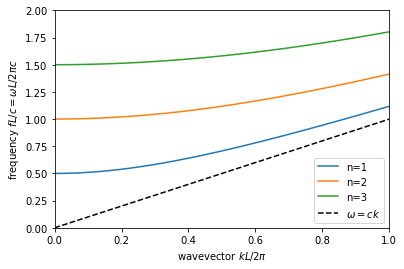

In [2]:
k = np.linspace(0, 1, 1000)
plt.plot(k, np.sqrt(k**2 + (1/2)**2))
plt.plot(k, np.sqrt(k**2 + (2/2)**2))
plt.plot(k, np.sqrt(k**2 + (3/2)**2))
plt.plot(k, k, "k--")
plt.ylim(0,2)
plt.xlim(0,1)
plt.legend(["n=1","n=2","n=3","$\\omega=ck$"],loc="lower right")
plt.ylabel("frequency $f L/c = \\omega L/2\\pi c$")
plt.xlabel("wavevector $kL/2\pi$")
plt.savefig("pset3sol_p2a.pdf")

## Part (d)

Since the default boundary conditions in Meep are PEC, we can just make a $20 \times 1$ (choosing distance units so that $L=1$, or equivalently choosing distance in units of $L$), and then put PML "absorbing layers" in the $x$ direction. 

We then put in a `GaussianSource`, which creates a pulse current input, and use the built in `dft_ldos` feature, which Fourier-transforms the output electric field and computes the time-averaged power $-\Re \int \hat{\mathbf{J}}^* \hat{\mathbf{E}}$ from the Fourier-transformed fields and currents, and finally normalizes it by the current $|\hat{\mathbf{J}}|$ to obtain the power expended by a unit dipole at a set of frequencies.

You specify the frequencies in Meep (for both the source and the `dft_ldos`) as a center frequency and a bandwidth, and from the analytical solutions we are expecting interesting things to happen at multiples of `f = 0.5` (the mode cutoff frequencies $\omega(0)/2\pi$ in $c/L$ units).   So, we will look at a bandwidth $f \in [0.25, 3.75]$, corresponding to `fcen = 2` and `df = 3.5`.

For choosing the thickness `dpml` of the PML, the runtime `T`, and the `resolution`, in principle these should be $\infty$ to get the exact Maxwell solutions.  In practice, we start at modest values [and keep doubling them until solutions converge](https://meep.readthedocs.io/en/latest/FAQ/#checking-convergence), as explained in the Meep FAQ.

<AxesSubplot:xlabel='X', ylabel='Y'>

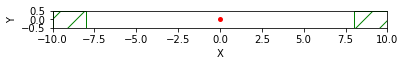

In [3]:
# cell width, including PML
w = 20

# convergence parameters: Meep should converge to the 
# exact solution as these go to infinity
dpml = 2 # PML absorber thickness
resolution = 20 # pixels/L
T = 8000 # runtime … need to run long enough for fields to decay away

fcen = 2
df = 1.75 * 2


sim = mp.Simulation(cell_size=(w,1),
                    boundary_layers=[mp.PML(dpml, direction=mp.X)],
                    sources=[mp.Source(src=mp.GaussianSource(fcen,fwidth=df*2),
                                       component=mp.Ez, center=(0,0))],
                    symmetries=[mp.Mirror(mp.X), mp.Mirror(mp.Y)],
                    resolution=resolution)

# It's always good to plot the computational cell to make sure it 
# looks the way we want.
sim.plot2D()

In [4]:
ldos = mp.Ldos(fcen, df, 300)
sim.run(mp.dft_ldos(ldos=ldos), until_after_sources=8000)

FloatProgress(value=0.0, description='0% done ', max=8001.428571462631)

ldos0:, 0.25, -0.031138286887906708
ldos0:, 0.2617056856187291, -0.061749412976217326
ldos0:, 0.2734113712374582, 0.08976938943512597
ldos0:, 0.28511705685618727, -0.04066073502794109
ldos0:, 0.29682274247491636, -0.03390613014769218
ldos0:, 0.3085284280936455, 0.07013341183526113
ldos0:, 0.3202341137123746, -0.04394797010820831
ldos0:, 0.3319397993311037, -0.014519396621917527
ldos0:, 0.34364548494983277, 0.05351775751070134
ldos0:, 0.35535117056856186, -0.043496656735875244
ldos0:, 0.36705685618729095, -0.0009904541187162825
ldos0:, 0.3787625418060201, 0.039449867034074486
ldos0:, 0.3904682274247492, -0.040760212157498574
ldos0:, 0.40217391304347827, 0.008292828855011477
ldos0:, 0.41387959866220736, 0.027589679913287975
ldos0:, 0.42558528428093645, -0.03664678884096681
ldos0:, 0.43729096989966554, 0.014399291992159852
ldos0:, 0.4489966555183946, 0.017681478259804394
ldos0:, 0.4607023411371237, -0.03175720996975682
ldos0:, 0.4724080267558528, 0.01808305069793951
ldos0:, 0.484113712374

Now, let's plot the solution: the power (LDOS) as a function of frequency.

(0.0, 10.0)

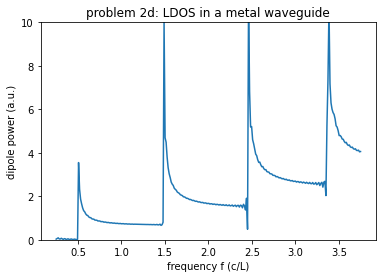

In [5]:
plt.plot(mp.get_ldos_freqs(ldos), np.abs(sim.ldos_data))
plt.title("problem 2d: LDOS in a metal waveguide")
plt.xlabel("frequency f (c/L)")
plt.ylabel("dipole power (a.u.)")
plt.ylim(0,10)

Just as expected, we see a few interesting features:

* Below the lowest cutoff ($f < 0.5$), the power is $\approx 0$.
* There is a sharp ($\sim 1/\sqrt{f - f_0}$) divergence at every mode cutoff frequency (multiples of $0.5$).
* Overall, the power goes up and up as more modes are added.

There is also a numerical artifact: some [ringing artifacts](https://en.wikipedia.org/wiki/Ringing_artifacts) where the spectrum oscillates rapidly near the cutoff.  This typically arises if we stop the simulation too soon, before the modes have completely decayed away, causing the Fourier transform to be [windowed](https://en.wikipedia.org/wiki/Window_function); this is also called [spectral leakage](https://en.wikipedia.org/wiki/Spectral_leakage).   Near the cutoffs, we have very long-lived resonances (we will see later that the [group velocity](https://en.wikipedia.org/wiki/Group_velocity) is zero at cutoffs), so it takes a long time for the field to decay away (and PML has a difficult time absorbing such ["slow-light" modes](https://en.wikipedia.org/wiki/Slow_light) as well).

But the numerics are good enough to see clear qualitative agreement with the theory.  To show *quantitative* agreement, we could plot the theoretical curve on top of the Meep curve, but this requires very careful attention to normalization and units.